# SMARTEOLE Wake Steering SCADA Data Overview

This notebook provides an overview of the data from the SMARTEOLE_WakeSteering_SCADA_1minData.csv file.

/home/boujuan/miniforge3/envs/wind_forecasting_cuda/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/boujuan/miniforge3/envs/wind_forecasting_cuda/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


Dataset Overview:
Number of rows: 134661
Number of columns: 288

Columns and Sample Values:
time:
['2020-02-20 16:14:00', '2020-04-02 07:07:00', '2020-04-16 20:23:00', '2020-05-15 17:31:00', '2020-04-06 21:43:00']

active_power_1_avg:
[2053.351, -1.124, 85.356, 313.501, -1.061]

active_power_1_min:
[2022.156, -1.312, 72.496, 232.076, -1.163]

active_power_1_max:
[2105.75, -0.896, 95.075, 477.747, -0.896]

active_power_1_std:
[20.284, 0.08, 7.445, 78.939, 0.062]

active_power_1_count:
[59, 55, 56, 57, 57]

active_power_2_avg:
[2032.467, -1.171, -0.726, 272.239, -2.517]

active_power_2_min:
[1814.376, -1.526, -12.569, 248.765, -2.774]

active_power_2_max:
[2063.686, -0.832, 5.975, 304.188, -2.315]

active_power_2_std:
[45.441, 0.145, 4.464, 18.013, 0.116]

active_power_2_count:
[59, 59, 53, 59, 56]

active_power_3_avg:
[None, -0.438, -1.749, 448.734, -0.333]

active_power_3_min:
[None, -0.694, -1.963, 340.575, -0.512]

active_power_3_max:
[None, -0.235, -1.483, 512.608, -0.107]

active_p

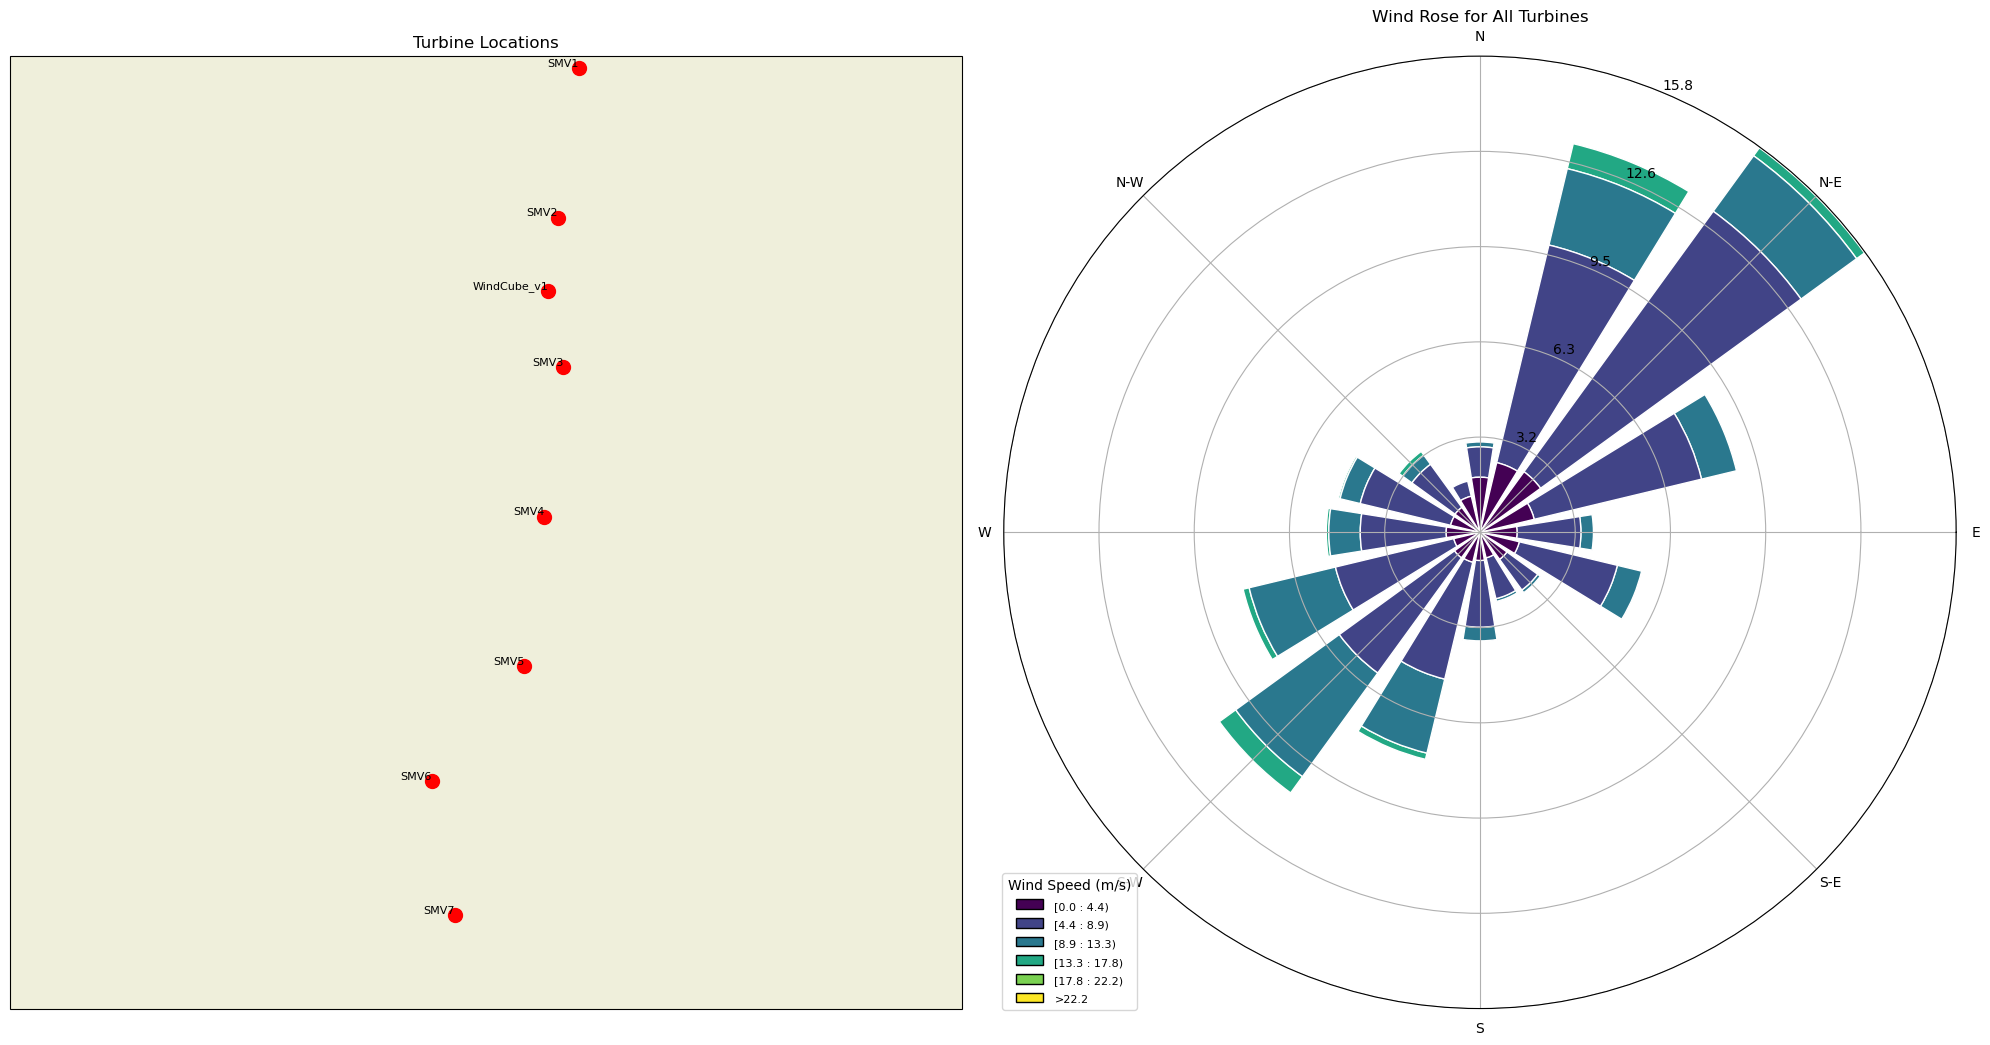

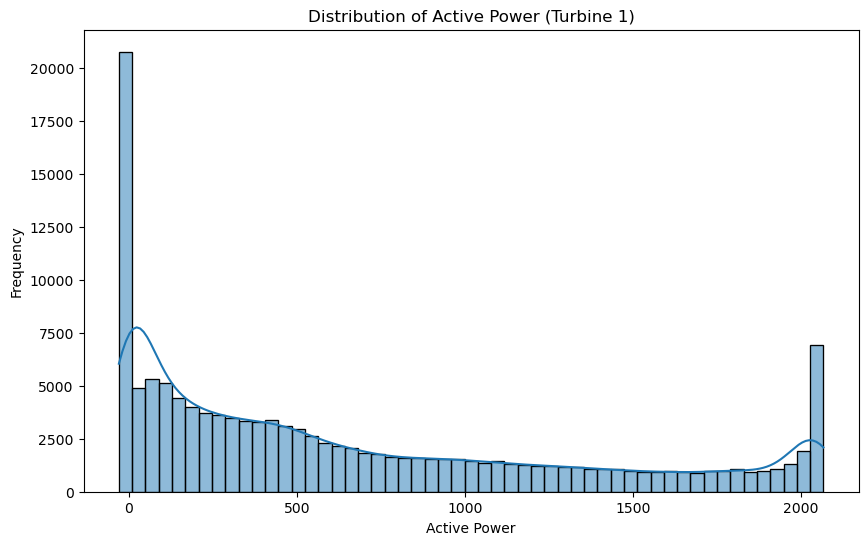

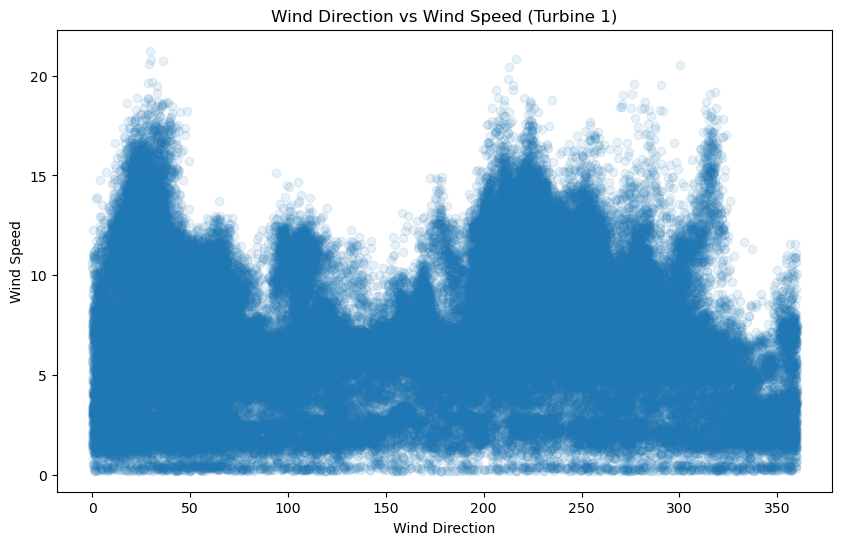

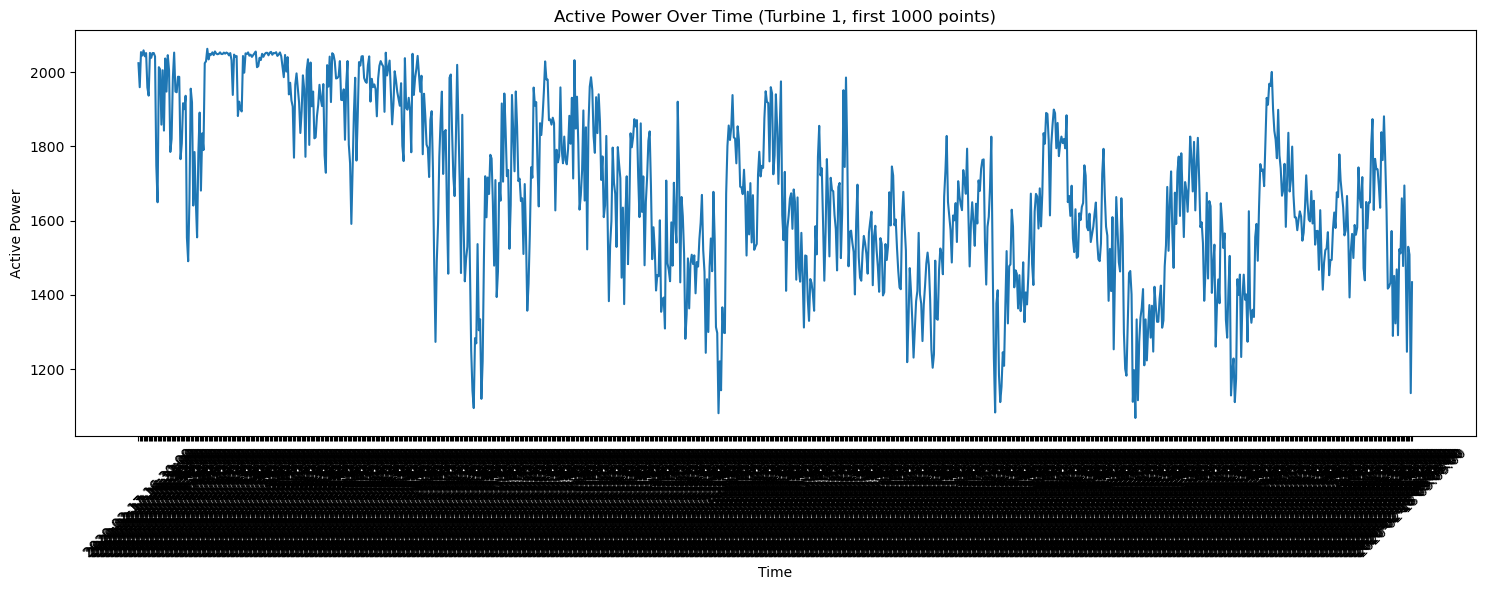


Unique Values in derate columns:
derate_1: shape: (2, 2)
┌──────────┬────────┐
│ derate_1 ┆ counts │
│ ---      ┆ ---    │
│ i64      ┆ u32    │
╞══════════╪════════╡
│ 1        ┆ 1621   │
│ 0        ┆ 133040 │
└──────────┴────────┘
derate_2: shape: (2, 2)
┌──────────┬────────┐
│ derate_2 ┆ counts │
│ ---      ┆ ---    │
│ i64      ┆ u32    │
╞══════════╪════════╡
│ 1        ┆ 5287   │
│ 0        ┆ 129374 │
└──────────┴────────┘
derate_3: shape: (2, 2)
┌──────────┬────────┐
│ derate_3 ┆ counts │
│ ---      ┆ ---    │
│ i64      ┆ u32    │
╞══════════╪════════╡
│ 0        ┆ 115122 │
│ 1        ┆ 19539  │
└──────────┴────────┘
derate_4: shape: (2, 2)
┌──────────┬────────┐
│ derate_4 ┆ counts │
│ ---      ┆ ---    │
│ i64      ┆ u32    │
╞══════════╪════════╡
│ 0        ┆ 124958 │
│ 1        ┆ 9703   │
└──────────┴────────┘
derate_5: shape: (2, 2)
┌──────────┬────────┐
│ derate_5 ┆ counts │
│ ---      ┆ ---    │
│ i64      ┆ u32    │
╞══════════╪════════╡
│ 1        ┆ 3054   │
│ 0       

In [1]:
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from windrose import WindroseAxes
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Load the SCADA CSV file
scada_file_path = "inputs/SMARTEOLE-WFC-open-dataset/SMARTEOLE_WakeSteering_SCADA_1minData.csv"
df = pl.read_csv(scada_file_path)

# Load the coordinates CSV file
coords_file_path = "inputs/SMARTEOLE-WFC-open-dataset/SMARTEOLE_WakeSteering_Coordinates_staticData.csv"
coords_df = pl.read_csv(coords_file_path)

# Display basic information about the dataset
print("Dataset Overview:")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

# Display column names vertically with a few sample values
print("\nColumns and Sample Values:")
sample_data = df.sample(5, seed=42)
for col in df.columns:
    print(f"{col}:")
    print(sample_data[col].to_list())
    print()

# Check for missing values
print("\nMissing Values:")
null_counts = df.null_count()
for col in df.columns:
    count = null_counts[col][0]
    if count > 0:
        print(f"{col}: {count}")

# Create a figure with two subplots side by side
fig = plt.figure(figsize=(20, 10))

# Plot the map with turbine locations
ax1 = fig.add_subplot(121, projection=ccrs.PlateCarree())
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')

# Plot turbine locations
for row in coords_df.iter_rows(named=True):
    ax1.plot(row['Longitude'], row['Latitude'], 'ro', markersize=10, transform=ccrs.PlateCarree())
    ax1.text(row['Longitude'], row['Latitude'], row['Turbine'], fontsize=8, ha='right', va='bottom', transform=ccrs.PlateCarree())

ax1.set_extent([2.79, 2.81, 49.83, 49.85])
ax1.set_title('Turbine Locations')

# Plot windrose for all wind directions (handling NaN values)
ax2 = fig.add_subplot(122, projection='windrose')
wind_directions = []
wind_speeds = []

for i in range(1, 8):
    dir_data = df[f'wind_direction_{i}_avg'].to_numpy()
    speed_data = df[f'wind_speed_{i}_avg'].to_numpy()
    valid_mask = ~(np.isnan(dir_data) | np.isnan(speed_data))
    wind_directions.extend(dir_data[valid_mask])
    wind_speeds.extend(speed_data[valid_mask])

ax2.bar(wind_directions, wind_speeds, normed=True, opening=0.8, edgecolor='white')
ax2.set_legend(title="Wind Speed (m/s)")
ax2.set_title('Wind Rose for All Turbines')

plt.tight_layout()
plt.show()

# Plot distribution of active power for turbine 1
plt.figure(figsize=(10, 6))
sns.histplot(df['active_power_1_avg'].to_numpy(), kde=True)
plt.title('Distribution of Active Power (Turbine 1)')
plt.xlabel('Active Power')
plt.ylabel('Frequency')
plt.show()

# Plot wind direction vs wind speed for turbine 1
plt.figure(figsize=(10, 6))
plt.scatter(df['wind_direction_1_avg'], df['wind_speed_1_avg'], alpha=0.1)
plt.title('Wind Direction vs Wind Speed (Turbine 1)')
plt.xlabel('Wind Direction')
plt.ylabel('Wind Speed')
plt.show()

# Plot active power over time for turbine 1
plt.figure(figsize=(15, 6))
plt.plot(df['time'][:1000], df['active_power_1_avg'][:1000])
plt.title('Active Power Over Time (Turbine 1, first 1000 points)')
plt.xlabel('Time')
plt.ylabel('Active Power')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Display unique values for derate columns
print("\nUnique Values in derate columns:")
for i in range(1, 8):
    print(f"derate_{i}: {df[f'derate_{i}'].value_counts()}")

# Display summary statistics for numeric columns
print("\nSummary Statistics:")
numeric_cols = df.select(pl.col(pl.NUMERIC_DTYPES)).columns
print(df.select(numeric_cols).describe())